# 复现报告2 

# 因子选股：最优动量因子

本文复现了方正证券《枯树生花：基于日内模式的动量因子革新》。研报中使用了全A股作为股票池，在最后也使用了中证500成分股。由于在复现最优动量因子过程中需要用到分时数据，全A股数据比较庞大，故本文采用回测区间内中证500的所有历史成分股，共1052只。如果该因子确实有效，那么复现结果应当不至于与研报相差很大。最后本文也将基于动态调整的中证500成分股进行策略回测。

## 1. 因子复现

最优动量因子的逻辑是不同时段的交易者成分具有系统性差异，会导向不同的市场行为特征，从而形成不同的日内模式。研报将每日分为5个时段，分别计算收益：

R(1) = P(今开) / P(昨收) - 1

R(2) = P(10:30) / P(9:30) - 1

R(3) = P(11:30) / P(10:30) - 1

R(4) = P(14:00) / P(13:00) - 1

R(5) = P(15:00) / P(14:00) - 1

将过去20日五个时段的收益率加总得到5个动量因子M1，M2，M3，M4，M5。然后将这五个动量因子加权求均值，权重以ICIR为目标进行优化，得到最优动量因子。

以下代码为计算五个动量因子的过程，同时加入传统动量因子M0（过去20日增长率）以作对照。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import atrader as at

In [2]:
begin_date_1 = '2013-01-01'
end_date_1 = '2017-06-01'
begin_date_2 = '2017-06-02'
end_date_2 = '2019-12-31'

In [3]:
#获取交易日期
days = at.get_trading_days('SSE', begin_date_1, end_date_2)
day_list = [x.strftime('%Y-%m-%d') for x in days]

In [7]:
#获取历史中证500成分股
target_set = {}
for day in day_list:
    new_list = list(at.get_code_list('zz500',date = day).code)
    target_list = list(target_set)
    target_list = target_list + new_list
    target_set = set(target_list)
stock_list = list(target_set)
stock_df = pd.DataFrame(stock_list,columns = ['stock'])
stock_df.to_csv('data/stock_name.csv') #股票列表保存到本地

In [116]:
print('股票数量：',len(stock_list))

股票数量： 1052


In [ ]:
#下载股票行情数据
for i in range(0,len(stock_list),1):
    stock = stock_list[i]
    data1 = at.get_kdata(target_list = [stock],
                     frequency = 'min',
                     fre_num = 60, 
                     begin_date = begin_date_1,
                     end_date = end_date_1,
                     fq=1,
                     fill_up = True,
                     df = True,
                     sort_by_date=True)
    data2 = at.get_kdata(target_list = [stock],
                     frequency = 'min',
                     fre_num = 60, 
                     begin_date = begin_date_2,
                     end_date = end_date_2,
                     fq=1,
                     fill_up = True,
                     df = True,
                     sort_by_date=True)
    
    stk_data = pd.concat([data1,data2])
    stk_data.loc[:,'time'] = stk_data.loc[:,'time'].values.astype(str)
    stk_data.to_csv('data/{0}.csv'.format(stock))

In [64]:
#计算动量因子
for i in range(0,len(stock_list),1):
    stock = stock_list[i]
    
    stk_data = pd.read_csv('data/{0}.csv'.format(stock), index_col = 0)
    
    price_data = stk_data[['time','open','close','volume']]
    price_data.loc[:,'rate'] = price_data.loc[:,'close'] / price_data.loc[:,'open'] - 1
    
    date_list = [x[:10] for x in price_data.time.values]
    mom_data = pd.DataFrame(index = date_list, columns = ['close','volume','M1','M2','M3','M4','M5'])
    mom_data = mom_data.reset_index()
    mom_data = mom_data.drop_duplicates(subset = 'index').set_index('index')
    
    for j in range(0,len(price_data),4):
        nowtime = price_data.iloc[j,0]
        if nowtime[11:13] == '10':
            mom_data.loc[nowtime[:10],'close'] = price_data.iloc[j+3,2]
            mom_data.loc[nowtime[:10],'volume'] = price_data.iloc[j:j+4,3].sum()
            mom_data.loc[nowtime[:10],['M2','M3','M4','M5']] = price_data.iloc[j:j+4,4].values
            if nowtime[:10] != date_list[0]: #不是第一个日期
                mom_data.loc[nowtime[:10],'M1'] = price_data.iloc[j,1] / price_data.iloc[j-1,2] - 1
        else:
            print(stock,i,j,nowtime)
        
    mom_data.to_csv('data/{0}_day.csv'.format(stock))

    #以下报错的股票在修改csv文件后重新计算了因子，这里展示是为了告知数据库有误

sse.600747 96 4276 1970-01-01T00:00:00.000000000
sse.600747 96 4280 1970-01-01T00:00:00.000000000
sse.600747 96 4284 1970-01-01T00:00:00.000000000
sse.600747 96 4288 1970-01-01T00:00:00.000000000
sse.600747 96 4292 1970-01-01T00:00:00.000000000
sse.600747 96 4296 1970-01-01T00:00:00.000000000
sse.600747 96 4300 1970-01-01T00:00:00.000000000
sse.600747 96 4304 1970-01-01T00:00:00.000000000
sse.600747 96 4308 1970-01-01T00:00:00.000000000
sse.600747 96 4312 1970-01-01T00:00:00.000000000
sse.600747 96 4316 2017-06-02T15:00:00.000000000
sse.600747 96 4320 2017-06-05T15:00:00.000000000
sse.600747 96 4324 2017-06-06T15:00:00.000000000
sse.600747 96 4328 2017-06-07T15:00:00.000000000
sse.600747 96 4332 2017-06-08T15:00:00.000000000
sse.600747 96 4336 2017-06-09T15:00:00.000000000
sse.600747 96 4340 2017-06-12T15:00:00.000000000
sse.600747 96 4344 2017-06-13T15:00:00.000000000
sse.600747 96 4348 2017-06-14T15:00:00.000000000
sse.600747 96 4352 2017-06-15T15:00:00.000000000
sse.600747 96 4356 2

sse.600747 96 6740 2019-12-06T15:00:00.000000000
sse.600747 96 6744 2019-12-09T15:00:00.000000000
sse.600747 96 6748 2019-12-10T15:00:00.000000000
sse.600747 96 6752 2019-12-11T15:00:00.000000000
sse.600747 96 6756 2019-12-12T15:00:00.000000000
sse.600747 96 6760 2019-12-13T15:00:00.000000000
sse.600747 96 6764 2019-12-16T15:00:00.000000000
sse.600747 96 6768 2019-12-17T15:00:00.000000000
sse.600747 96 6772 2019-12-18T15:00:00.000000000
sse.600747 96 6776 2019-12-19T15:00:00.000000000
sse.600747 96 6780 2019-12-20T15:00:00.000000000
sse.600747 96 6784 2019-12-23T15:00:00.000000000
sse.600747 96 6788 2019-12-24T15:00:00.000000000
sse.600747 96 6792 2019-12-25T15:00:00.000000000
sse.600747 96 6796 2019-12-26T15:00:00.000000000
sse.600747 96 6800 2019-12-27T15:00:00.000000000
sse.600747 96 6804 2019-12-30T15:00:00.000000000
sse.600747 96 6808 2019-12-31T15:00:00.000000000
sse.600575 439 4276 1970-01-01T00:00:00.000000000
sse.600575 439 4280 1970-01-01T00:00:00.000000000
sse.600575 439 428

In [4]:
# 将日数据处理为月度数据
# 每月最后一个交易日
months = np.vectorize(lambda x: x.month)(days)
month_end = days[pd.Series(months) != pd.Series(months).shift(-1)]   # 月末的日期序列
month_end_list = [x.strftime('%Y-%m-%d') for x in month_end]

#由于后台数据缺失，将缺失的两日替换为最近有数据的一天
month_end_list[month_end_list.index('2019-02-28')] = '2019-02-26'
month_end_list[month_end_list.index('2019-04-30')] = '2019-04-29'

In [242]:
#计算每月月末的动量值
close_df = pd.DataFrame(index = month_end_list)
rate_df = pd.DataFrame(index = month_end_list)
M0_df = pd.DataFrame(index = month_end_list)
M1_df = pd.DataFrame(index = month_end_list)
M2_df = pd.DataFrame(index = month_end_list)
M3_df = pd.DataFrame(index = month_end_list)
M4_df = pd.DataFrame(index = month_end_list)
M5_df = pd.DataFrame(index = month_end_list)

for i in range(0,len(stock_list),1):
    stock = stock_list[i]
    
    day_data = pd.read_csv('data/{0}_day.csv'.format(stock), index_col = 0)
    
    #剔除未开盘：无交易量
    day_data = day_data[day_data.volume > 0]
    #剔除数据奇怪：close为0，M5为inf
    day_data = day_data[day_data.close > 0]
    day_data = day_data[day_data.M5 != np.inf]
    
    month_data = pd.DataFrame(index = month_end_list, columns = ['close','rate','M0','M1','M2','M3','M4','M5'])
    
    for j in month_end_list:
        if j in day_data.index:
            month_data.loc[j,'close'] = day_data.loc[j,'close']
            d = list(day_data.index).index(j)
            #月末当天还不知道收盘价，因此计算动量因子不包括当天
            month_data.loc[j,['M1','M2','M3','M4','M5']] = day_data.iloc[(d - 20):d,2:7].sum().values
            month_data.loc[j,'M0'] = day_data.iloc[d-1,0] / day_data.iloc[(d-21),0] - 1
    
    #最后计算月收益
    month_data.loc[:,'rate'] = (- month_data.close.diff(-1) / month_data.close).values
    
    month_data.to_csv('data/{0}_month.csv'.format(stock))
    
    close_df[stock] = month_data['close'].values
    rate_df[stock] = month_data['rate'].values
    M0_df[stock] = month_data['M0'].values
    M1_df[stock] = month_data['M1'].values
    M2_df[stock] = month_data['M2'].values
    M3_df[stock] = month_data['M3'].values
    M4_df[stock] = month_data['M4'].values
    M5_df[stock] = month_data['M5'].values

close_df.to_csv('data/close.csv')
rate_df.to_csv('data/rate.csv')
M0_df.to_csv('data/M0.csv')
M1_df.to_csv('data/M1.csv')
M2_df.to_csv('data/M2.csv')
M3_df.to_csv('data/M3.csv')
M4_df.to_csv('data/M4.csv')
M5_df.to_csv('data/M5.csv')

In [7]:
#计算每月IC值和相关系数

def get_IC(def_month_list):

    IC_df = pd.DataFrame(index = def_month_list, columns = ['M0','M1','M2','M3','M4','M5'])
    corr_dict = {}
    corr_sum = pd.DataFrame(np.zeros((6,6)),index = ['M0','M1','M2','M3','M4','M5'], 
                            columns = ['M0','M1','M2','M3','M4','M5'])

    for i in def_month_list:
        month_df = pd.DataFrame([rate_df.loc[i,:].values,
                                M0_df.loc[i,:].values,
                                M1_df.loc[i,:].values,
                                M2_df.loc[i,:].values,
                                M3_df.loc[i,:].values,
                                M4_df.loc[i,:].values,
                                M5_df.loc[i,:].values], 
                                index = ['rate','M0','M1','M2','M3','M4','M5']).T
        month_df = month_df.dropna()
        if len(month_df) > 0:
            IC_df.loc[i,:] = month_df.corr(method = 'spearman').iloc[0,1:].values
            corr = month_df.corr().iloc[1:,1:].copy()
            corr_dict[i] = corr
            corr_sum = corr_sum + corr

    corr_avg = corr_sum / len(def_month_list)
    corr_sse = pd.DataFrame(np.zeros((6,6)),index = ['M0','M1','M2','M3','M4','M5'], 
                            columns = ['M0','M1','M2','M3','M4','M5'])
    for i in corr_dict:
        corr_sse = corr_sse + (corr_dict[i] - corr_avg)**2
    corr_t = corr_avg / (corr_sse/len(corr_dict))**0.5
    
    IC_ds = pd.DataFrame(index = ['Mean','Std','t','ICIR'], columns = ['M0','M1','M2','M3','M4','M5'])
    IC_ds.loc['Mean'] = IC_df.mean().values
    IC_ds.loc['Std'] = IC_df.std().values
    IC_ds.loc['t'] = (IC_df.mean() / (IC_df.std()/len(IC_df)**0.5)).values
    IC_ds.loc['ICIR'] = IC_df.mean() / IC_df.std()
    
    #计算最优动量权重
    IC_df = IC_df.astype(float)
    sigma = np.mat((-IC_df).cov().iloc[1:,1:].values)
    mu = np.mat((-IC_df).mean()[1:].values).T
    wt = sigma.I * mu
    ICIRop = (wt.T*mu)[0,0] / ((wt.T*sigma*wt)[0,0])**0.5
    
    return IC_df, np.array(wt).T[0], ICIRop, IC_ds, corr_avg, corr_t

研报所用数据的时间大概在2013.4至2013.8，复现亦同。

In [8]:
test_month_list = month_end_list[3:56]

In [11]:
IC_df_test, wt_test, ICIRop_test, IC_ds_test, corr_avg_test, corr_t_test = get_IC(test_month_list)

In [12]:
IC_ds_test

,M0,M1,M2,M3,M4,M5
Mean,-0.05185,-0.0011682,-0.0083536,-0.025836,-0.057543,-0.014469
Std,0.16444,0.086172,0.13928,0.091871,0.091338,0.088353
t,-2.2955,-0.098693,-0.43665,-2.0473,-4.5864,-1.1922
ICIR,-0.31532,-0.013557,-0.059979,-0.28122,-0.63,-0.16377


将IC值统计特征与研报对比，可以看到尽管样本空间不同，但是在统计量的数值上仍有多处非常接近。

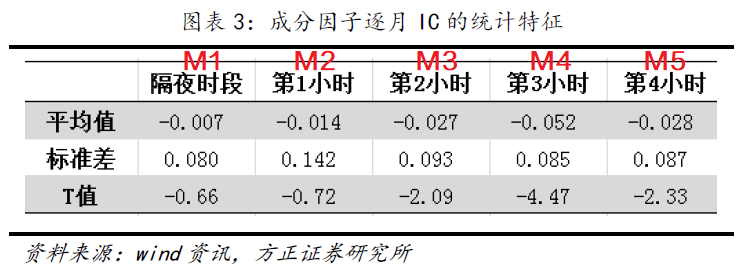

下表展示了数值比较接近的统计量。

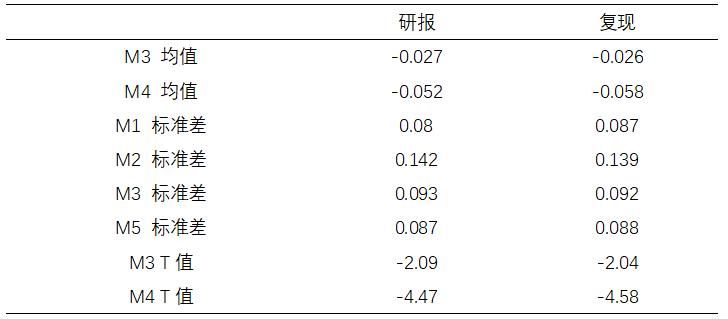

In [13]:
corr_avg_test.iloc[1:,1:]

,M1,M2,M3,M4,M5
M1,1.00000,-0.15666,-0.08771,-0.09947,-0.11700
M2,-0.15666,1.00000,0.01239,0.06439,-0.14232
M3,-0.08771,0.01239,1.00000,-0.05595,-0.06604
M4,-0.09947,0.06439,-0.05595,1.00000,-0.10415
M5,-0.11700,-0.14232,-0.06604,-0.10415,1.00000


同样地，五个动量因子的相关系数与研报也非常接近。

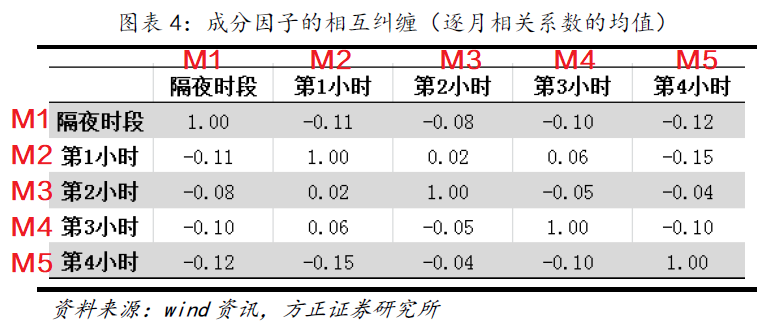

In [14]:
corr_t_test.iloc[1:,1:]

,M1,M2,M3,M4,M5
M1,inf,-1.53236,-1.05420,-1.09866,-1.38356
M2,-1.53236,inf,0.12243,0.56421,-1.12472
M3,-1.05420,0.12243,inf,-0.68493,-0.76423
M4,-1.09866,0.56421,-0.68493,inf,-1.06261
M5,-1.38356,-1.12472,-0.76423,-1.06261,inf


相关系数T值与研报相差较大，可能是计算方式有不同。

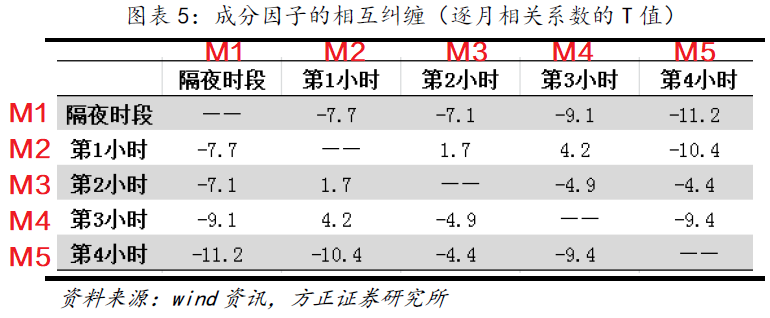

In [15]:
wt_test

array([ 1.08244383, -3.97375203,  3.64446208,  9.78491768,  3.59264927])

In [16]:
ICIRop_test

0.822960382074401

研报上的最优权重为(-0.47, -0.59, 0.76, 1.5, 1)，最优ICIR为2.85，与复现的差距较大。

# 2.分层回测

In [17]:
#根据权重计算最优动量因子值
def getMop (wt):
    return M1_df * wt[0] + M2_df * wt[1] + M3_df * wt[2] + M4_df * wt[3] + M5_df * wt[4]

In [18]:
Mop_test = getMop(wt_test)

In [76]:
#粗糙的交易者类

class roughTrader:

    def __init__(self, money, price,buy_fee = 0, sell_fee = 0):
        self.money = money
        self.value = self.money
        self.price = price
        self.buy_fee = buy_fee
        self.sell_fee = sell_fee
        
        self.record = {'date':[],'money':[],'value':[]} #资金记录
        self.long_pos = pd.DataFrame(index = ['price','amount']) #多头持仓
        self.win_times = 0 #盈利次数
        self.loss_times = 0 #亏损次数
        self.win = 0 #盈利额
        self.loss = 0 #亏损额

    def long_open(self, date, open_list): #多头开仓
        n = len(open_list)
        pos = (self.money / (1 + self.buy_fee)) / n #每个股票资金平均分配
        stk_open = self.price.loc[[date],open_list].T
        stk_open['amount'] = pos / stk_open.iloc[:,0]
        price = stk_open.iloc[:,0]
        amount = stk_open.iloc[:,1]
        self.money -= np.dot(price, amount) * (1 + self.buy_fee)
        for stk in open_list:
            self.long_pos[stk] = stk_open.loc[stk,:].values
                
    def long_close(self, date, close_list): #多头平仓
        if len(close_list) > 0:
            close_price = self.price.loc[date,close_list].values
            close_oldprice = self.long_pos.loc['price',close_list].values
            self.win_times += (close_price > close_oldprice).sum()
            self.loss_times += (close_price < close_oldprice).sum()

            close_amount = self.long_pos.loc['amount', close_list].values
            close_win = close_amount * (close_price * (1 - self.sell_fee) - close_oldprice)
            self.win += (close_win[close_win > 0]).sum()
            self.loss += (close_win[close_win < 0]).sum()

            self.money += (close_amount * close_price * (1 - self.sell_fee)).sum()

            self.long_pos = self.long_pos.drop(close_list, axis = 1)
        
    def long_close_all(self,date):
        if self.long_pos.shape[1] > 0:
            close_list = self.long_pos.columns.values
            self.long_close(date, close_list)
    
    def stop_loss(self, date, ratio):
        if self.long_pos.shape[1] > 0:
            long_list = self.long_pos.columns.values
            stk_price = self.price.loc[date, long_list]
            stk_oldprice = self.long_pos.loc['price',long_list]
            stk_rate = 1 - stk_price / stk_oldprice
            close_list = stk_rate[stk_rate > ratio].index.values
            self.long_close(date, close_list)
    
    def valuation(self,date): #仅估值
        if self.long_pos.shape[1] > 0: #有持仓时才模拟卖出
            long_list = self.long_pos.columns.values
            unclose_price = self.price.loc[date, long_list].values
            unclose_amount = self.long_pos.loc['amount',long_list].values
            unclose_money = np.dot(unclose_price, unclose_amount)
        else:
            unclose_money = 0
        self.value = self.money + unclose_money
        
    def add_record(self,date): #添加记录
        self.record['date'].append(date)
        self.record['money'].append(self.money)
        self.record['value'].append(self.value)
    
    def show_record(self):
        rec_df = pd.DataFrame(self.record).set_index('date')
        rec_df['return'] = rec_df.pct_change()['value'].values
        rec_df['netValue'] = rec_df['value'].values / rec_df['value'].values[0]
        rec_df['accReturn'] = rec_df['netValue'] - 1
        return rec_df
        
    def analysis(self, rf = 0, index_close = 0): #index_close should be a series
        items = pd.Series(index = ['Annualized return','Annualized volatility',
                                   'Sharpe ratio','Max draw down'])
        
        value = self.show_record()['value']
        ret = self.show_record()['return']
        n = len(value)
        
        ann_ret = (value[-1] / value[0])**(252 / n) - 1
        items['Annualized return'] = ann_ret
        
        ann_std = 252**0.5 * ret.std()
        items['Annualized volatility'] = ann_std
        
        items['Sharpe ratio'] = (ann_ret - rf) / ann_std
        
        #计算最大回撤
        mdd = 0
        for i in range(n):
            new_mdd = (1 - value[i:] / value[i]).max()
            if new_mdd > mdd:
                mdd = new_mdd
        items['Max draw down'] = max(0,mdd)
        
        #计算胜率
        items['Win times'] = self.win_times
        items['Loss times'] = self.loss_times
        items['Winning rate'] = self.win_times / (self.loss_times + self.win_times)
        
        #计算盈亏比
        avg_profit = self.win / self.win_times
        items['Avg. profit'] =  avg_profit
        avg_loss = - self.loss / self.loss_times
        items['Avg. loss'] = avg_loss
        items['Profit loss ratio'] = avg_profit /  avg_loss
        
        if isinstance(index_close,pd.Series):
            trade_days = list(value.index)
            idx_close = index_close[trade_days]
            ann_idx_ret = (idx_close[-1] / idx_close[0])**(252 / n) - 1
            items['Annualized return of Index'] = ann_idx_ret
            
            idx_ret = idx_close.pct_change()
            cov = pd.DataFrame([ret,idx_ret]).T.cov().iloc[0,1]
            var = idx_ret.var()
            beta = cov / var
            y_mean = ret.mean()
            x_mean = idx_ret.mean()
            alpha = y_mean - beta * x_mean
            items['Annualized Alpha'] = (alpha + 1)**252 - 1
            items['Beta'] = beta
            
            TD = ret - idx_ret
            annTE = (252**0.5*TD.std())
            items['Annualized TE'] = annTE
            items['IR'] = (ann_ret - ann_idx_ret)/ annTE
        return items

In [20]:
#根据月度得到该区间内的所有交易日
def get_day_list(month_list):
    return day_list[day_list.index(month_list[0]): (day_list.index(month_list[-1])+1)]

In [21]:
test_day_list = get_day_list(test_month_list)

In [46]:
#计算日度收盘价和交易量

close_day = pd.DataFrame(index = day_list)
volume_day = pd.DataFrame(index = day_list)

for i in range(len(stock_list)):
    stock = stock_list[i]
    stk_day = pd.read_csv('data/{0}_day.csv'.format(stock),index_col = 0)
    if len(stk_day) < len(day_list):
        close_day[stock] = np.nan
        volume_day[stock] = np.nan
        if len(stk_day) > 0:
            close_day.loc[list(stk_day.index),stock] = stk_day['close'].values
            volume_day.loc[list(stk_day.index),stock] = stk_day['volume'].values
    else:
        close_day[stock] = stk_day.loc[day_list,'close'].values
        volume_day[stock] = stk_day.loc[day_list,'volume'].values

close_day = close_day.fillna(method = 'ffill').fillna(0)
volume_day = volume_day.fillna(0)
close_day.to_csv('data/close_day.csv')
volume_day.to_csv('data/volume_day.csv')

In [47]:
#分层回测,组合1因子值最大
def backtest_port(factor_df, bt_day_list, n_port = 5):
    port_dict = {x:roughTrader(10000000,close_day) for x in range(1, n_port + 1)}
    for date in bt_day_list:
        #print(date)
        if date in month_end_list:
            volume = volume_day.loc[date]
            stk_list = volume[volume>0].index.values
            factor = factor_df.loc[date,stk_list].dropna()
            for i in range(1,n_port + 1):
                buy_list = factor[(factor > factor.quantile((5-i)/ n_port)) & 
                                  (factor < factor.quantile((5-i+1)/n_port))].index.values
                port_dict[i].long_close_all(date)
                port_dict[i].long_open(date, buy_list)
                port_dict[i].valuation(date)
                port_dict[i].add_record(date)
        else:
            for i in range(1,n_port + 1):
                port_dict[i].valuation(date)
                port_dict[i].add_record(date)

    acc_ret = pd.DataFrame(index = test_day_list)
    for i in range(1,n_port + 1):
        acc_ret['Portfolio %s' % i] = port_dict[i].show_record()['netValue'].values
    
    return acc_ret

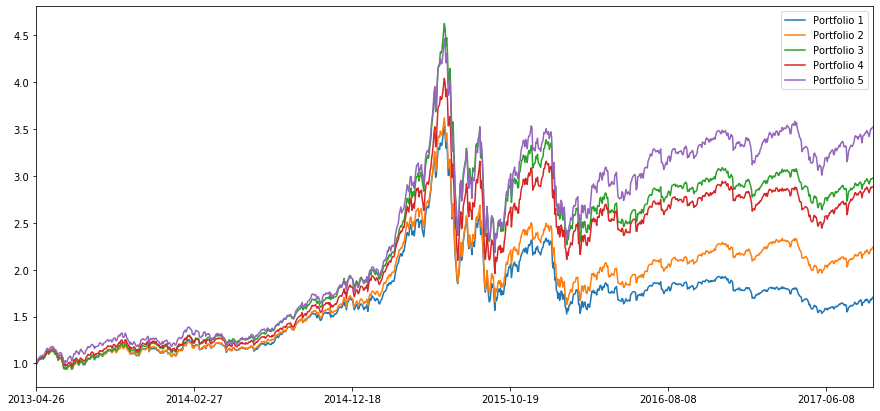

In [48]:
acc_ret_Mop = backtest_port(Mop_test, test_day_list)
acc_ret_Mop.plot(figsize = (15,7))
plt.show()

分层回测的图像看起来尚佳，但是组合3和组合4的净值表现次序与预期相反，而且在2015年左右一段时间组合3甚至取得最高累积收益率，这与研报中的情形有明显差别。

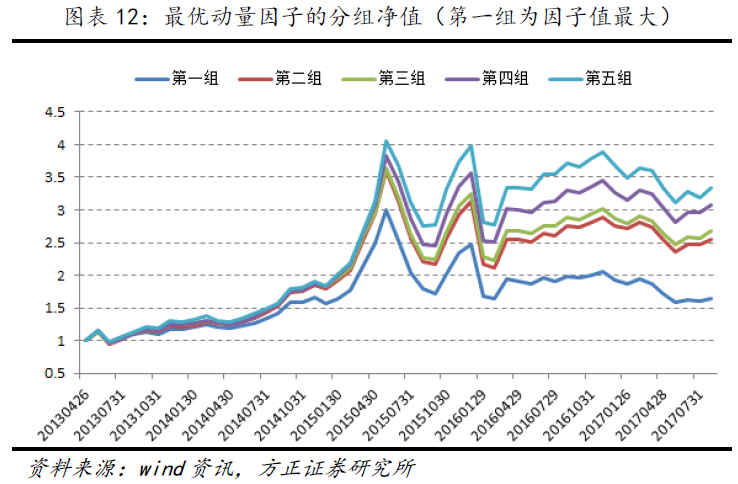

研报最后又用中证500成分股做了一遍分层回测，在单调性上与复现结果更为接近，都是组合3和组合4的收益纠缠不清，最终组合3的累积收益率都高于组合4。可见分层回测的结果与样本空间关系比较大。

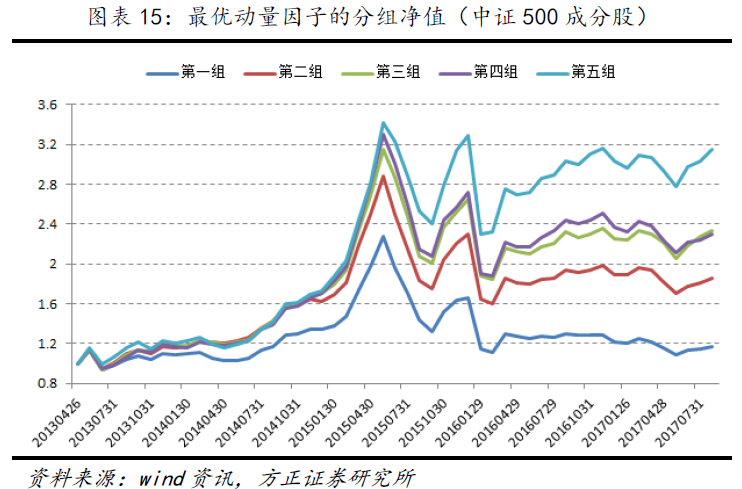

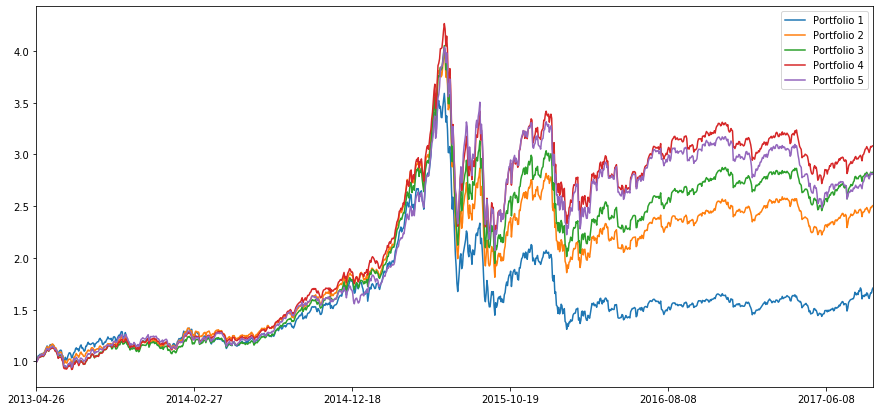

In [49]:
acc_ret_M0 = backtest_port(M0_df, test_day_list)
acc_ret_M0.plot(figsize = (15,7))
plt.show()

作为对照，传统动量因子的分层回测的单调性也不够理想。

# 3.策略回测

股票池为调仓当日的中证500成分股。

取动量因子最小的一组股票买入，每月调仓，不计交易费用。

最优动量因子先按样本内数据计算权重，然后用于样本外回测。

In [50]:
#将所有数据分为样本内和样本外
in_month_list = month_end_list[1:54]
out_month_list = month_end_list[54:]

In [51]:
print('样本内：', in_month_list[0], in_month_list[-1])
print('样本外：', out_month_list[0], out_month_list[-1])

样本内： 2013-02-28 2017-06-30
样本外： 2017-07-31 2019-12-31


In [52]:
IC_df_in, wt_in, ICIRop_in, IC_ds_in, corr_avg_in, corr_t_in = get_IC(in_month_list)

In [53]:
wt_in

array([ 1.10606088, -4.22523238,  3.24689994,  9.52040856,  2.5712059 ])

In [54]:
Mop_in = getMop(wt_in)

In [55]:
#策略回测函数
#threshold的负号表示小于其绝对值，正好表示大于其绝对值
def backtest(factor_df, day_list, threshold = -0.2):
    bt_out = roughTrader(100000000,close_day)
    for date in day_list:
        if date in month_end_list:
            stk_list = list(at.get_code_list('zz500',date = date).code)
            volume = volume_day.loc[date,stk_list]
            stk_list = volume[volume > 0].index.values
            factor = factor_df.loc[date,stk_list].dropna()
            if threshold < 0:
                buy_list = factor[factor < factor.quantile(-threshold)].index.values
            else:
                buy_list = factor[factor > factor.quantile(threshold)].index.values
            bt_out.long_close_all(date)
            bt_out.long_open(date, buy_list)
            bt_out.valuation(date)
            bt_out.add_record(date)
        else:
            bt_out.valuation(date)
            bt_out.add_record(date)
    return bt_out

In [57]:
out_day_list = get_day_list(out_month_list)

In [83]:
#获取中证500指数的收盘价
CSI500_out = at.get_kdata(target_list=['sse.000905'], frequency='day', fre_num=1, 
                          begin_date=out_day_list[0], end_date = out_day_list[-1],
                          fq = 1, fill_up = True, df = True, sort_by_date = False)
CSI500_out.time = CSI500_out.time.apply(lambda x: str(x)[:10])
CSI500_out = CSI500_out.set_index('time')
CSI500_close = CSI500_out['close']
out_acc = CSI500_out.loc[:,['close']] / CSI500_close[0]
out_acc.columns = ['CSI500']

先取股票池中因子值最小的20%买入。

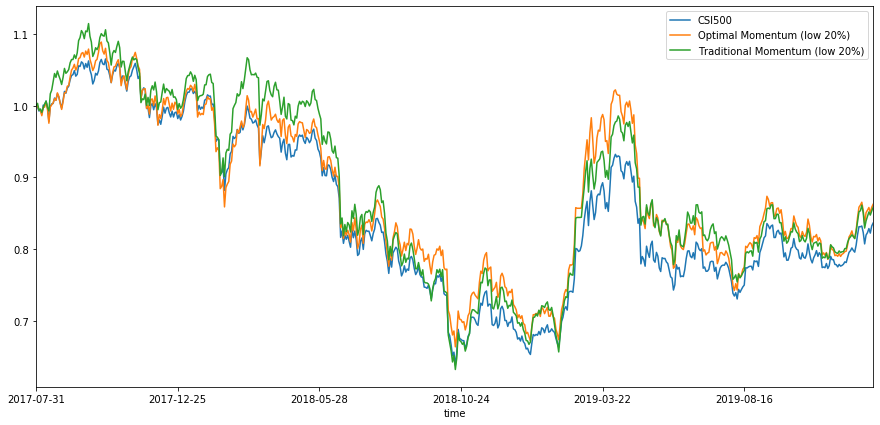

In [84]:
bt_Mop = backtest(Mop_in, out_day_list, -0.2)
bt_M0 = backtest(M0_df, out_day_list, -0.2)
out_acc['Optimal Momentum (low 20%)'] = bt_Mop.show_record()['netValue'].values
out_acc['Traditional Momentum (low 20%)'] = bt_M0.show_record()['netValue'].values
out_acc.plot(figsize = (15,7))
plt.show()

In [85]:
bt_Mop.analysis(index_close = CSI500_close) #最优动量因子回测统计

Annualized return                -0.06097
Annualized volatility             0.25778
Sharpe ratio                     -0.23652
Max draw down                     0.39050
Win times                      1177.00000
Loss times                     1600.00000
Winning rate                      0.42384
Avg. profit                   89084.76772
Avg. loss                     74119.44759
Profit loss ratio                 1.20191
Annualized return of Index       -0.07323
Annualized Alpha                  0.02757
Beta                              1.11979
Annualized TE                     0.06160
IR                                0.19893
dtype: float64

In [86]:
bt_M0.analysis(index_close = CSI500_close) #传统动量因子回测统计

Annualized return                -0.06298
Annualized volatility             0.25327
Sharpe ratio                     -0.24868
Max draw down                     0.43299
Win times                      1227.00000
Loss times                     1549.00000
Winning rate                      0.44200
Avg. profit                   79282.49486
Avg. loss                     71950.93494
Profit loss ratio                 1.10190
Annualized return of Index       -0.07323
Annualized Alpha                  0.02238
Beta                              1.08438
Annualized TE                     0.07122
IR                                0.14378
dtype: float64

从图像上看很明显最优动量和传统动量策略都打败了指数，取得了正的Alpha。但是无论是图像还是统计数值，都不能体现出最优动量策略有明显优势。虽然最优动量策略的Alpha和IR比传统动量策略高一点点，但是回测区间前半段传统动量策略的收益更高，到后半段最优动量策略的收益才赶上来。最优动量策略的盈亏比稍微高一点，但胜率略低。两者的最大回撤都在40%左右，实操中需要增加风险控制。

下面尝试选取因子值最小的10%买入。

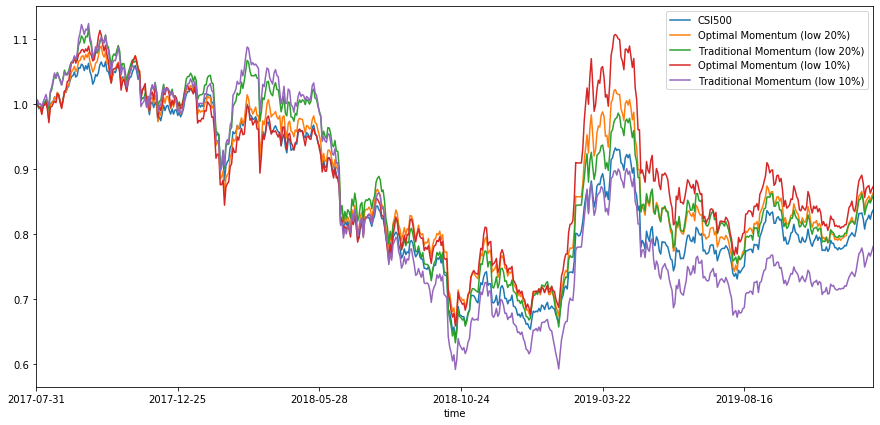

In [87]:
bt_Mop_10 = backtest(Mop_in, out_day_list, -0.1)
bt_M0_10 = backtest(M0_df, out_day_list, -0.1)
out_acc['Optimal Momentum (low 10%)'] = bt_Mop_10.show_record()['netValue'].values
out_acc['Traditional Momentum (low 10%)'] = bt_M0_10.show_record()['netValue'].values
out_acc.plot(figsize = (15,7))
plt.show()

In [88]:
bt_Mop_10.analysis(index_close = CSI500_close)

Annualized return                 -0.05631
Annualized volatility              0.27399
Sharpe ratio                      -0.20552
Max draw down                      0.40898
Win times                        587.00000
Loss times                       808.00000
Winning rate                       0.42079
Avg. profit                   198283.80236
Avg. loss                     159804.74892
Profit loss ratio                  1.24079
Annualized return of Index        -0.07323
Annualized Alpha                   0.03953
Beta                               1.16558
Annualized TE                      0.08826
IR                                 0.19164
dtype: float64

In [89]:
bt_M0_10.analysis(index_close = CSI500_close)

Annualized return                 -0.10017
Annualized volatility              0.26539
Sharpe ratio                      -0.37746
Max draw down                      0.47412
Win times                        605.00000
Loss times                       793.00000
Winning rate                       0.43276
Avg. profit                   163590.97519
Avg. loss                     152501.67330
Profit loss ratio                  1.07272
Annualized return of Index        -0.07323
Annualized Alpha                  -0.01361
Beta                               1.11496
Annualized TE                      0.09091
IR                                -0.29643
dtype: float64

将比例降至10%后最优因子策略体现出了明显优势，取到了比20%时更高的累积收益率和Alpha。而传统因子策略甚至没有打败市场。不过在回测区间的前半段传统因子策略仍旧是最佳的。

一方面可见市场风格在2018年有了明显的结构性转变，最优动量因子只是在近期更为有效。另一方面，比例参数也对策略收益有较大的影响，对于最优动量因子来说应缩小股票数量，选择因子值极小的一批，而传统因子应容纳更多股票，因子值不算最小的也应纳入，这与之前分层回测表现出的单调性是相印证的。

正如研报所提示的，因子有效性的判断都是基于历史数据，未来市场依然会发生变化。本文虽然用数据证实了无论最优动量因子和还是传统动量因子都有一定的有效性，但是在不同时间呈现的有效性不同，在实操中需要根据市场变化及时调整策略。